## CP5: Data selection, p-values, hypothesis testing and significance interpretation

In [60]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.special import erfinv
from scipy.integrate import quad
from scipy.stats import norm
from scipy.optimize import minimize

In [61]:
class Linear:
    # Class for linear background function
    def __init__(self, intercept=20., slope=-1., XMIN=0., XMAX=20., NBINS=100):
        # background parameters
        self.XMIN = XMIN
        self.XMAX = XMAX
        self.intercept = intercept
        self.slope = slope
        # chose number of bins that is appropriate for the size of the statistics sample
        self.NBINS = NBINS
        self.mass = []
        
    def evaluate(self , t):
        # evaluate the expected value of function for a given t
        return self.intercept + self.slope * t
    
    def maxval(self):
        # get the maximum value of funciton ie the y intercept as negative gradient
        # would normally just use self.intercept but code template called a method named maxval
        return self.intercept + self.slope * self.XMIN

    def next(self):
        # returns one linearly distributed random number in the XMIN to XMAX range
        doLoop = True
        # keep trying until one is accepted
        while(doLoop ):
            # start with uniform random number in [lolimit , hilimit)
            #x = np.random.uniform(self.lolimit , self.hilimit)
            x = np.random.uniform(self.XMIN ,self.XMAX)
            y1 = self.evaluate(x)
            y2 = np.random.uniform(0, self.maxval())
            # use box method to accept x when a second uniform random number < the function value at x
            if (y2 < y1):
                filtered_x = x
                self.mass.append(filtered_x)
                return filtered_x
        
    def integral(self, x1, x2):
        # integrate linear function with limits x1 to x2
        return quad(self.evaluate, x1, x2)

In [62]:
class Gaussian:
    # class for Gaussian signal function
    def __init__(self, mean=10., sigma=0.5, NBINS=100):
        # signal parameters
        self.mean = mean
        self.sigma = sigma
        # chose number of bins that is appropriate for the size of the statistics sample
        self.NBINS = NBINS
        self.mass = []
    
    def next(self):
        # returns one Gaussian distributed random number from gaussian with given mean and sigma
        x = np.random.normal(self.mean, self.sigma)
        self.mass.append(x)
        return x
    
    def func(self, x):
        # evaluate the expected value of function for a given x
        return norm.pdf(x, self.mean, self.sigma)
    
    def integral(self, x1, x2):
        # integrate Gaussian function with limits x1 to x2
        return quad(self.func, x1, x2)

In [63]:
class SignalWithBackground:
    # class to generate either a signal or background count
    def __init__(self, mean, sigma, sig_fraction, intercept, slope, XMIN, XMAX):
        # make linear background and Gaussian signal objects
        self.sig_fraction = sig_fraction
        self.signal = Gaussian(mean, sigma)
        self.background = Linear(intercept, slope, XMIN, XMAX)
        # empty lists for separate sig and bgd as well as combined list
        self.mass_sig = []
        self.mass_bgd = []
        self.mass = []
        
    def next(self):
        # add one count of signal or background with probability given by the expected signal fraction
        q = np.random.uniform ()
        if( q < self.sig_fraction ):
            # if here , we will draw x from signal distribution
            filtered_x = self.signal.next()
            self.mass_sig.append(filtered_x)
        else:
            # if here , we will draw x from background distribuion
            filtered_x = self.background.next()
            self.mass_bgd.append(filtered_x)
            
        self.mass.append(filtered_x)
        return filtered_x 

In [165]:
def singleToy(nevents_sig = 300, nevents_bgd = 10000, show = True, fit = False, fit_ax_i = 2):
        # one run of a toy experiment
        sig_fraction = nevents_sig /( nevents_bgd + nevents_sig)
        # background parameters
        XMIN = 0.
        XMAX = 20.
        intercept = 20.
        slope = -1.
        # signal parameters
        mean = 10.
        sigma = 0.5
        # chose number of bins that is appropriate for the size of the statistics sample
        NBINS = 100
        #Create the pdf
        pdf = SignalWithBackground(mean, sigma, sig_fraction, intercept, slope, XMIN, XMAX)
        
        # populates sig, bgd and combined lists with the given number of total points
        for i in range( nevents_sig + nevents_bgd ): pdf.next()

        # retrieve the mass values for signal , background and their sum
        data = pdf.mass
        sig_data = pdf.mass_sig
        bgd_data = pdf.mass_bgd
        
        # plot things on same page
        myRange = (XMIN , XMAX)
        fig , axs = plt.subplots(3,1, sharex='col', figsize=(8, 12))
        
        axs[0].set_title("Signal distribution (" + str(len(sig_data )) + " entries)")
        axs[1].set_title("Background distribution (" + str(len(bgd_data )) + " entries)")
        axs[2].set_title("Total distribution (" + str(len(data)) + " entries)")
        axs[2].set_xlabel('X')
        
        axs[0].hist(sig_data , bins=NBINS , range=myRange, density=fit)
        # keep the counts and bin edges of second and third hists for fitting
        bgd_N_obs, bgd_bin_edges, _ = axs[1].hist(bgd_data , bins = NBINS, density = fit)
        tot_N_obs, tot_bin_edges, _ = axs[2].hist(data , bins = NBINS, density = fit)
        
        N_obs_list = [bgd_N_obs, tot_N_obs]
                
        if fit:
            # passing fit=True means fits for H0 and H1 are carried out on normalised hists
            tot_bin_edges = np.array(tot_bin_edges)
            half_bin_width = (tot_bin_edges[1] - tot_bin_edges[0]) / 2
            xs = (tot_bin_edges + half_bin_width)[:-1]
            
            # rough initial guess hard coded from trial and error
            initial_guess = [-4e-3, 0.12]
            # H0 fit using mininize, Nelder-mead worked fine when not worried about parameter errors
            optimize_result1 = minimize(H0_chi2_equiv, initial_guess, args=(xs, N_obs_list[fit_ax_i - 1]), method = 'Nelder-Mead')
            if show:
                # print details of fit if requested
                print('H0 fit result:')
                print(optimize_result1)
                print('')
            best_m, best_c = optimize_result1.x
            # plot best fitting line on top of hist
            axs[fit_ax_i].plot(xs, H0_func(xs, best_m, best_c), 'r', label='H0 fit')

            initial_guess = [-0.02, 0.6, 0.04]
            # H1 fit using minimize
            optimize_result2 = minimize(H1_chi2_equiv, initial_guess, args=(xs, N_obs_list[fit_ax_i - 1]), method = 'Nelder-Mead')
            if show:
                print('H1 fit result:')
                print(optimize_result2)
                print('')
            best_m, best_c, best_A = optimize_result2.x
            axs[fit_ax_i].plot(xs, H1_func(xs, best_m, best_c, best_A), label='H1 fit')
            axs[fit_ax_i].legend(loc='best')
        
        if not show:
            # won't show plots if requested, ie for when we repeat 1000 times
            plt.close(fig)
            
        if fit:
            # return minimum chi2 for H0 and H1
            return optimize_result1.fun, optimize_result2.fun

In [65]:
def H0_func(xs, m, c):
    # evaluate linear function, this time for a whole list of bin positions so can return an array
    return m * xs + c

In [66]:
def H1_func(xs, m, c, A):
    # evaluate linear background + Gaussian signal for list of bin positions
    mean = 10.0
    sigma = 0.5
    signal = norm.pdf(xs, mean, sigma)
    bgd = m * xs + c
    bgd = bgd / quad(H0_func, xs[0], xs[-1], args=(m, c))[0]
    # Both terms are normalised separately so signal strength A (between 0 and 1 for no signal to all signal) keeps sum normalised
    N_expect = A * signal + (1 - A) * bgd
    return N_expect

In [157]:
def H0_chi2_equiv(params, xs, N_obs):
    # chi2 equivalent to log-likelihood for H0, returns value of chi2 for given gradient m and intercept c
    m, c = params
    N_expect = m * xs + c
    # normalise to be safe even though using a normalised histogram anyway
    N_expect = N_expect / quad(H0_func, xs[0], xs[-1], args=(m, c))[0]
    # occasionally zero observed counts in high x bins or negative counts predicted, so force to be tiny instead of < 0
    for i,N in enumerate(N_expect):
        if N <= 0:
            N_expect[i] = 1e-6
    for i,N in enumerate(N_obs):
        if N <= 0:
            N_obs[i] = 1e-6
    # expression [4] from notes
    chi2 = 2 * np.sum(N_expect - N_obs + N_obs * np.log(N_obs / N_expect))
    return chi2

In [158]:
def H1_chi2_equiv(params, xs, N_obs):
    # chi2 equivalent to log-likelihood for H1, returns value of chi2 for given background gradient m intercept c and signal strength A
    # H1 allows background m and c to vary but is defined with fixed signal mean and sigma
    mean = 10.0
    sigma = 0.5
    m, c, A = params
    signal = norm.pdf(xs, mean, sigma)
    bgd = m * xs + c
    bgd = bgd / quad(H0_func, xs[0], xs[-1], args=(m, c))[0]
    N_expect = A * signal + (1 - A) * bgd
    for i,N in enumerate(N_expect):
        if N <= 0:
            N_expect[i] = 1e-6
    for i,N in enumerate(N_obs):
        if N <= 0:
            N_obs[i] = 1e-6
    chi2 = 2 * np.sum(N_expect - N_obs + N_obs * np.log(N_obs / N_expect))
    return chi2

# Problem 1

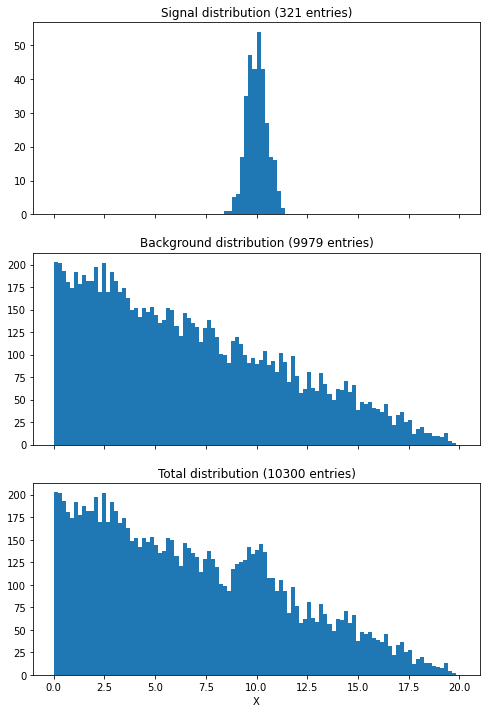

In [166]:
# single toy experiment
singleToy()

# Problem 2

In [203]:
# lambda
lam = 10000
# k
k = lam + 300

# Poisson tends to Gaussian with mean=lambda sigma=sqrt(lambda) from notes
nb_pts_gaussian = Gaussian(mean = lam, sigma = (lam)**0.5)
# haven't divided by entire integral for normalisation, instead used normalised Gaussian pdf
pvalue = nb_pts_gaussian.integral(k, np.inf)[0]
n_sigmas = erfinv (1 - pvalue) * np.sqrt (2)
print('pvalue is: ', pvalue)
print('n_sigmas is: ', n_sigmas)

pvalue is:  0.0013498980319969402
n_sigmas is:  3.2051549205206973


10300 is roughly 3.2 sigma from the mean with a probability of ~0.001 of seeing 10300 or greater counts appear randomly from the background alone. Therefore, we reject the null hypothesis that there is no signal.

# Problem 3

In [114]:
xmin = 0.0
xmax = 20.0
new_xmin = 5.0
new_xmax = 15.0

bgd = Linear()

# calculate area under linear function for original region (x=1 to x=20)
orig_area = bgd.integral(xmin, xmax)[0]
# calculate area under linear function for new region (x=5 to x=15)
new_area = bgd.integral(new_xmin, new_xmax)[0]

new_area_frac = (new_area / orig_area)
print(new_area_frac)

0.5


The number of expected background events in the region is half of the number expected from the full range as expected.

In [217]:
lam = 5000
k = lam + 300

nb_pts_gaussian = Gaussian(mean = lam, sigma = (lam)**0.5)
pvalue = nb_pts_gaussian.integral(k, np.inf)[0]
# Z-Score is given by distance from mean in units of sigma
n_sigmas = erfinv (1 - pvalue) * np.sqrt (2)
print('new pvalue is: ', pvalue)
print('new n_sigmas is: ', n_sigmas)

new pvalue is:  1.1045248513590364e-05
new n_sigmas is:  4.39562892080614


Now the probability of this occuring randomly from just the background is even smaller than in problem 2. This is because we are not just asking how likely is it to see an extra 300 events than expected, but specifically an extra 300 that all fall in a smaller range of x=5 to x=15. The deviation of about 4.4 sigma is more significant than in problem 2 as expected.

# Probem 4

H0 fit result:
 final_simplex: (array([[-0.00475662,  0.0954624 ],
       [-0.00475416,  0.0954137 ],
       [-0.00476088,  0.09554875]]), array([0.05427754, 0.05427754, 0.05427754]))
           fun: 0.05427753504304673
       message: 'Optimization terminated successfully.'
          nfev: 51
           nit: 27
        status: 0
       success: True
             x: array([-0.00475662,  0.0954624 ])

H1 fit result:
 final_simplex: (array([[-0.02185492,  0.43855523,  0.01920379],
       [-0.02185159,  0.43849268,  0.01915131],
       [-0.02185531,  0.43858958,  0.01919837],
       [-0.02186027,  0.43865228,  0.01913074]]), array([0.03678155, 0.03678158, 0.03678161, 0.03678167]))
           fun: 0.03678154693079716
       message: 'Optimization terminated successfully.'
          nfev: 95
           nit: 50
        status: 0
       success: True
             x: array([-0.02185492,  0.43855523,  0.01920379])



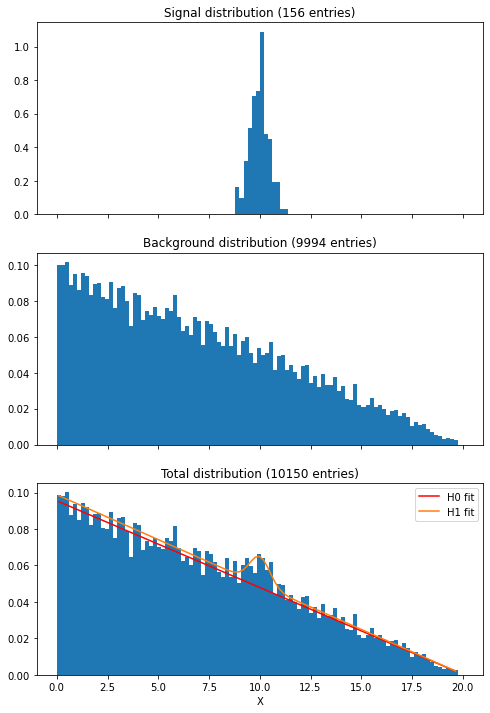

In [194]:
# single toy experiment
# arguments are (150 signal events, 10000 bgd events,  yes show plots, yes do a fit, fit to the third graph (index=2) ie the combined signal and background data) 
single_chi2_bgd, single_chi2_tot = singleToy(150, 10000, True, True, 2)

In [214]:
single_delta_chi2 = single_chi2_bgd - single_chi2_tot
p_value = scipy.stats.chi2.cdf(single_delta_chi2, df=1)
# didn't use 1-p in error function this time because cdf gives probability of a chi2 value as extreme or less so flipped it to just p_value 
n_sigmas = erfinv(p_value) * np.sqrt(2)
print('delta_chi2 is: ', single_delta_chi2)
print('p_value is: ', p_value)
print('n_sigmas is: ', n_sigmas)

delta_chi2 is:  0.017495988112249568
p_value is:  0.10523116378303153
n_sigmas is:  0.13227240117367478


# Problem 5

In [169]:
# for 1000 toy experiments
nb_toys = 1000
# make list of delta chi2's
delta_chi2s = []
for i in range(nb_toys):
    # number of signal events irrelevant as just fitting to background
    # don't plot, yes to fitting, fit to graph index 1 ie the linear background only 
    chi2_bgd, chi2_tot = singleToy(150, 10000, False, True, 1)
    delta_chi2s.append(chi2_bgd - chi2_tot)

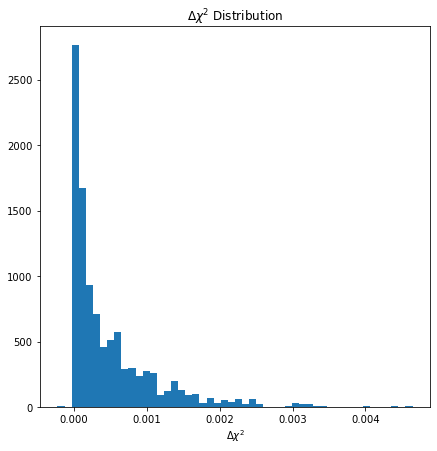

In [200]:
plt.figure(figsize=(7, 7))
# histogram of delta chi2's
pts_per_bin, bin_lefts, _ = plt.hist(delta_chi2s, bins=50, density=True)
plt.title(r'$\Delta \chi ^{2}$' + ' Distribution')
plt.xlabel(r'$\Delta \chi ^{2}$')
plt.show()

This looks like a chi2 distribution for one degree of freedom. This is expected because when fitting to the background only histogram, both H0 and H1 are equally good nested models (the Gaussian part of H1 will go to ~0) which is consistent with Wilk's theorem as there is one degree of freedom difference between the two models.

If I assume that both H0 and H1 are equally good when fitting to the signal + background data, I can roughly use the above plot to check how likely I am to get different values of delta chi2. The obtained value was about 0.017 for one particular toy experiment, which is way beyond the tail of the above plot so is almost impossible to obtain randomly assuming H0 and H1 are equally good. Therefore, this is evidence that H1 should be the preferred model for fitting to the signal + background data.